In [86]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings(action='ignore')

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import probplot

from glob import glob
from joblib import Parallel, delayed
from sklearn.preprocessing import minmax_scale
from sklearn.manifold import SpectralEmbedding
from mpl_toolkits.axes_grid1 import make_axes_locatable

## I. Introduction to Data

### 1. Order Book

Order book is an electronic list of buy and sell orders for a specific financial instruments organized by preice level. The order book data is a continuous represtation of market demand/supply and therefore it is considered as the top data source for market research.   

The table shown below is a snapshot of an order book of a stock. The **bid** column contains all intended buy orders, while the **ask** column contains all intended sell orders.

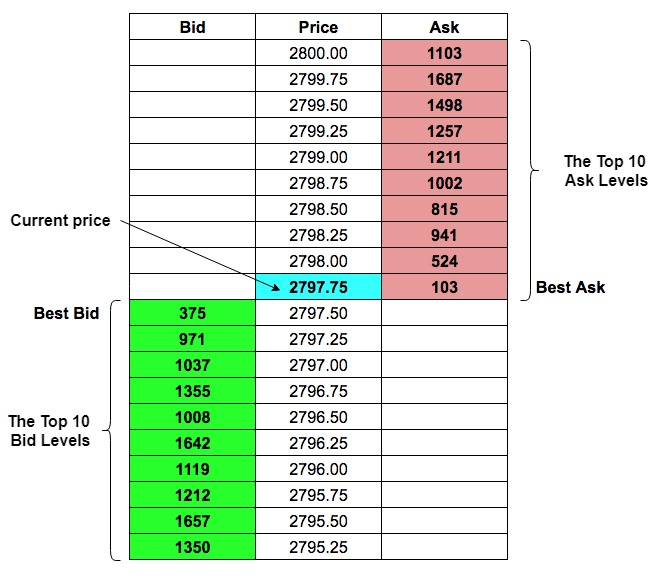

In [4]:
from IPython.display import Image
Image('/Users/zjy/Desktop/orderbook.PNG')

### 2. Requested Submission Template

In [48]:
Data_Directory = '/Users/zjy/Downloads/ML Project Data/'
sample_submission = pd.read_csv(Data_Directory + 'sample_submission.csv')
sample_submission.head()

,row_id,target
0,0-4,0.003048
1,0-32,0.003048
2,0-34,0.003048


This is the template we should follow when we submit our final result.

### 3. Training Data

In [49]:
train = pd.read_csv(Data_Directory + 'train.csv')
print("training data shape:", train.shape)
pd.concat([train.head(), train.tail()])

training data shape: (428932, 3)


,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357
428931,126,32767,0.002090


**stock_id**: ID of the stock

**time_id**: ID of the time bucket

**target**: realized volatility of the next 10-minute window under the same stock_id and time_id

In [7]:
train.groupby(['stock_id']).size()

stock_id
0      3830
1      3830
2      3830
3      3830
4      3830
       ... 
122    3830
123    3830
124    3830
125    3830
126    3830
Length: 112, dtype: int64

In [8]:
train.groupby(['time_id']).size()

time_id
5        112
11       112
16       112
31       112
62       112
        ... 
32751    112
32753    112
32758    112
32763    112
32767    112
Length: 3830, dtype: int64

In [9]:
for col in train.columns:
    print(col + ": " + str(len(train[col].unique())))

stock_id: 112
time_id: 3830
target: 414287


There are 112 stocks with 3830 different time_id and 414287 different target.

### 4. Testing Data

In [50]:
test = pd.read_csv(Data_Directory + 'test.csv')
print("testing data shape:", test.shape)
test.head()

testing data shape: (3, 3)


,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


We find that **row_id = stock_id + '-' + time_id**

## II. Exploratory Data Analysis

### 1. Target (Realized Volatility)

Mean:  0.0039
Median:  0.0030
Skew:  2.8226
Kurtosis:  14.9611


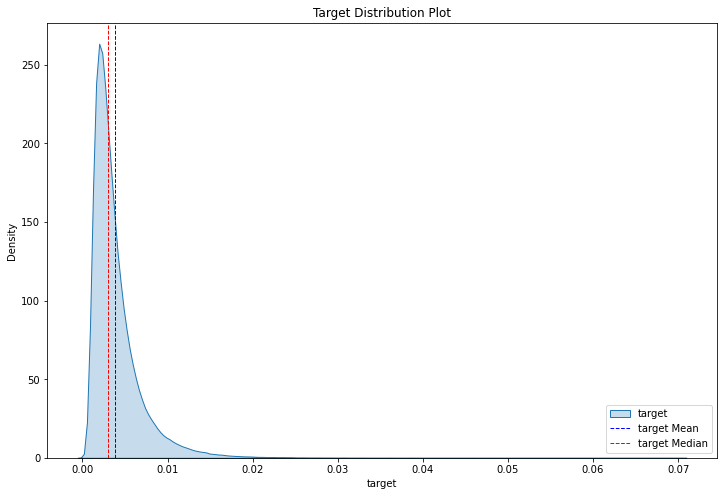

In [18]:
def visualization(target):
    print(f'Mean: {train[target].mean(): .4f}')
    print(f'Median: {train[target].median(): .4f}')
    print(f'Skew: {train[target].skew(): .4f}')
    print(f'Kurtosis: {train[target].kurtosis(): .4f}')

    plt.figure(figsize=(12, 8))
    sns.kdeplot(data=train[target], label=target, fill=True)
    plt.axvline(train[target].mean(), label=f'{target} Mean', color='b', linewidth=1, linestyle='--')
    plt.axvline(train[target].median(), label=f'{target} Median', color='r', linewidth=1, linestyle='--')
    plt.legend(loc=4, fontsize=10)
    plt.title('Target Distribution Plot')
    plt.show()
visualization('target')

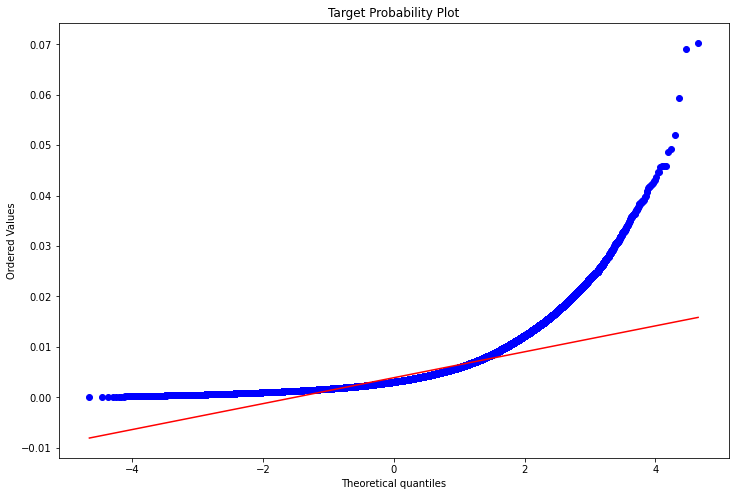

In [19]:
plt.figure(figsize=(12, 8))
probplot(train['target'], plot=plt)
plt.title('Target Probability Plot')
plt.show()

Red line stands for Normal Distribution.
Blue line stands for the sample data.
The probability plot shows that the distribution of target is far from Normal Distribution.

In [112]:
# compute the mean of the target for each stock_id
target_means = train.groupby('stock_id')['target'].mean()

# compute the standard deviation of the target for each stock_id
target_stds = train.groupby('stock_id')['target'].std()

# create a new dataframe, combing the mean and standard deviation of the target
target_means_stds = pd.concat([target_means, target_stds], axis=1)
target_means_stds.columns = ['mean', 'std']
target_means_stds.sort_values(by='mean', ascending=True, inplace=True)

target_means_stds


,mean,std
stock_id,,
43,0.001475,0.001227
29,0.001836,0.001232
46,0.001941,0.001455
125,0.002016,0.001703
41,0.002109,0.001613
...,...,...
27,0.006738,0.004435
75,0.006907,0.003982
6,0.006923,0.003323


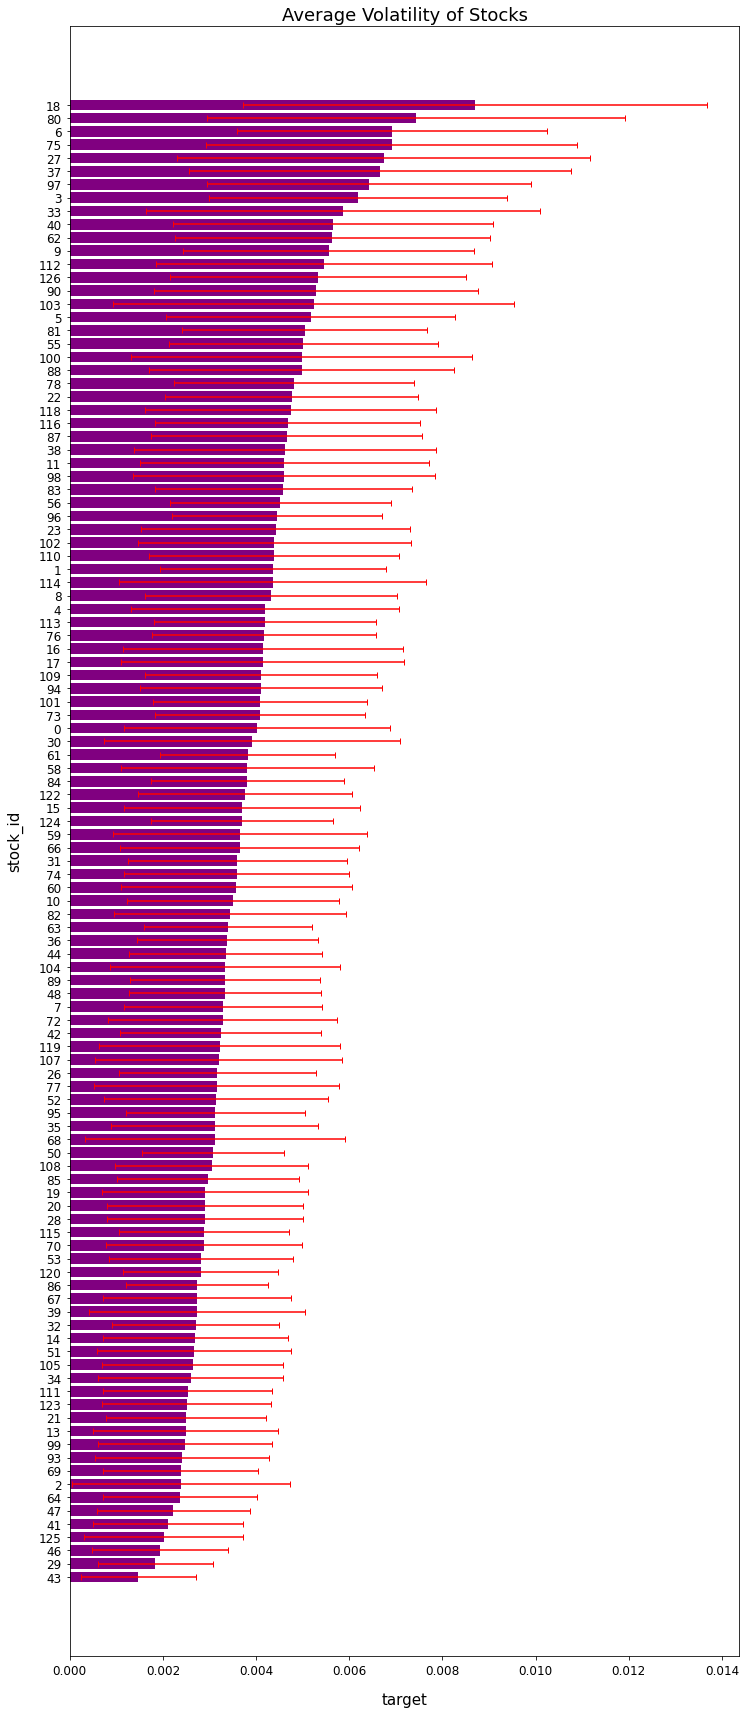

In [21]:
fig, ax = plt.subplots(figsize=(12, 30))
ax.barh(
    y=np.arange(len(target_means_stds)),
    color='purple',
    width=target_means_stds['mean'],
    xerr=target_means_stds['volatility'],
    ecolor='red',
    fill=True,
    capsize=3
)

ax.set_yticks(np.arange(len(target_means_stds)))
ax.set_yticklabels(target_means_stds.index)
ax.set_xlabel('target', size=15, labelpad=15)
ax.set_ylabel('stock_id', size=15, labelpad=15)
ax.tick_params(axis='x', labelsize=12, pad=5)
ax.tick_params(axis='y', labelsize=12, pad=5)
ax.set_title("Average Volatility of Stocks", size=18, pad=5)
plt.show()

Stocks are ranked by their mean volatilities, from most volatile to least volatile.

### 2. Time_id Distribution

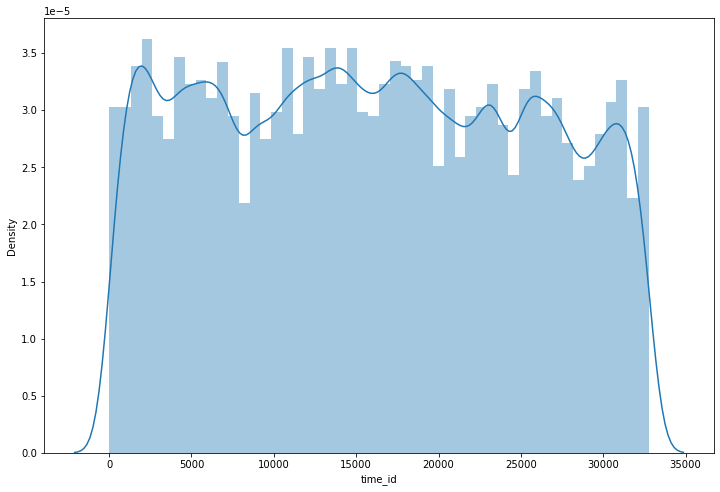

In [22]:
plt.figure(figsize=(12, 8))
sns.distplot(train['time_id'])
plt.show()

### 3. Target - Time_id Relationship

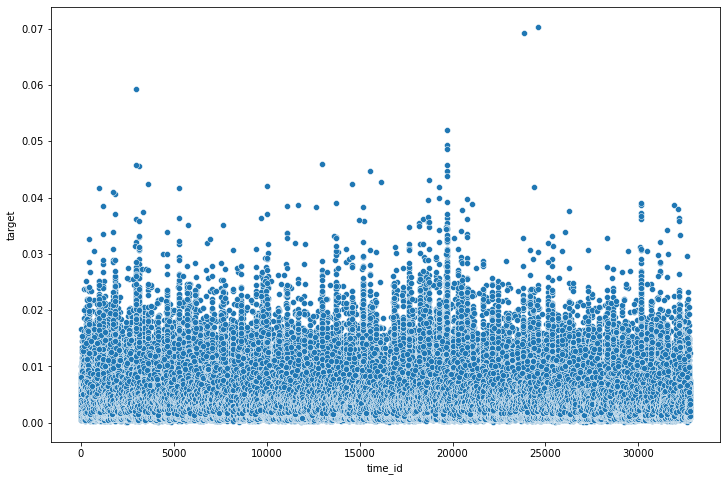

In [23]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=train, x="time_id", y="target")
plt.show()

From the scatterplot we can see more clearly that there are some extreme outliers of the realized volatility.

### 4. Difference between BOOK parquet & TRADE parquet

In the real market, not all Bid/Ask orders can be successfully transactioned, which depends on whether the Bid price meets the Ask price or not. So the **trade parquet** is expected to be **more sparse than** the **book parquet** (order book).

In [51]:
# book_train.parquet - all stocks & all times
book = pd.read_parquet(Data_Directory + "book_train.parquet")
print("book parquet shape:", book.shape)
pd.concat([book.head(), book.tail()])

book parquet shape: (167253289, 11)


,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100,0
167253284,32767,589,0.999662,0.999797,0.999527,0.999932,400,600,400,528,99
167253285,32767,590,0.999662,0.999797,0.999527,0.999932,400,500,400,528,99
167253286,32767,592,0.999527,0.999797,0.999391,0.999932,900,600,600,528,99
167253287,32767,596,0.999527,0.999797,0.999391,0.999932,900,700,600,628,99
167253288,32767,597,0.999527,0.999797,0.999391,0.999932,600,700,600,628,99


**seconds_in_bucket**: Number of seconds from the start of the bucket, always starting from 0.

**bid_price[1/2]**: Normalized prices of the most/second most competitive buy level.

**ask_price[1/2]**: Normalized prices of the most/second most competitive sell level.

**bid_size[1/2]**: The number of shares on the most/second most competitive buy level.

**ask_size[1/2]**: The number of shares on the most/second most competitive sell level.

In [52]:
# trade_train.parquet - all stocks & all times
trade =  pd.read_parquet(Data_Directory + "trade_train.parquet")
print("trade parquet shape:", trade.shape)
pd.concat([trade.head(), trade.tail()])

trade parquet shape: (38382741, 6)


,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0
38382736,32767,570,0.999932,100,1,99
38382737,32767,575,0.999932,100,1,99
38382738,32767,579,0.999797,300,3,99
38382739,32767,584,0.999854,172,2,99
38382740,32767,592,0.999662,400,5,99


**price**: The average price of executed transactions happening in one second.

**size**: The sum number of shares traded.

**order_count**: The number of unique trade orders taking place.

### 5. Exploration under a particular stock_id & time_id

In [57]:
stock_id = '1'
time_id = 5

book_study = pd.read_parquet(Data_Directory + f"book_train.parquet/stock_id={stock_id}")
book_study = book_study[book_study['time_id']==time_id]
book_study.loc[:,'stock_id'] = stock_id

trade_study = pd.read_parquet(Data_Directory + f"trade_train.parquet/stock_id={stock_id}")
trade_study = trade_study[trade_study['time_id']==time_id]
trade_study.loc[:, 'stock_id'] = stock_id

**5.1 Book (train) Parquet**

In [58]:
book_study.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.000754,1.001542,1.000689,1.001607,1,25,25,100,1
1,5,1,1.000754,1.001673,1.000689,1.001739,26,60,25,100,1
2,5,2,1.000754,1.001411,1.000623,1.001476,1,25,25,125,1
3,5,3,1.000754,1.001542,1.000689,1.001607,125,25,126,36,1
4,5,4,1.000754,1.001476,1.000623,1.001542,100,100,25,25,1


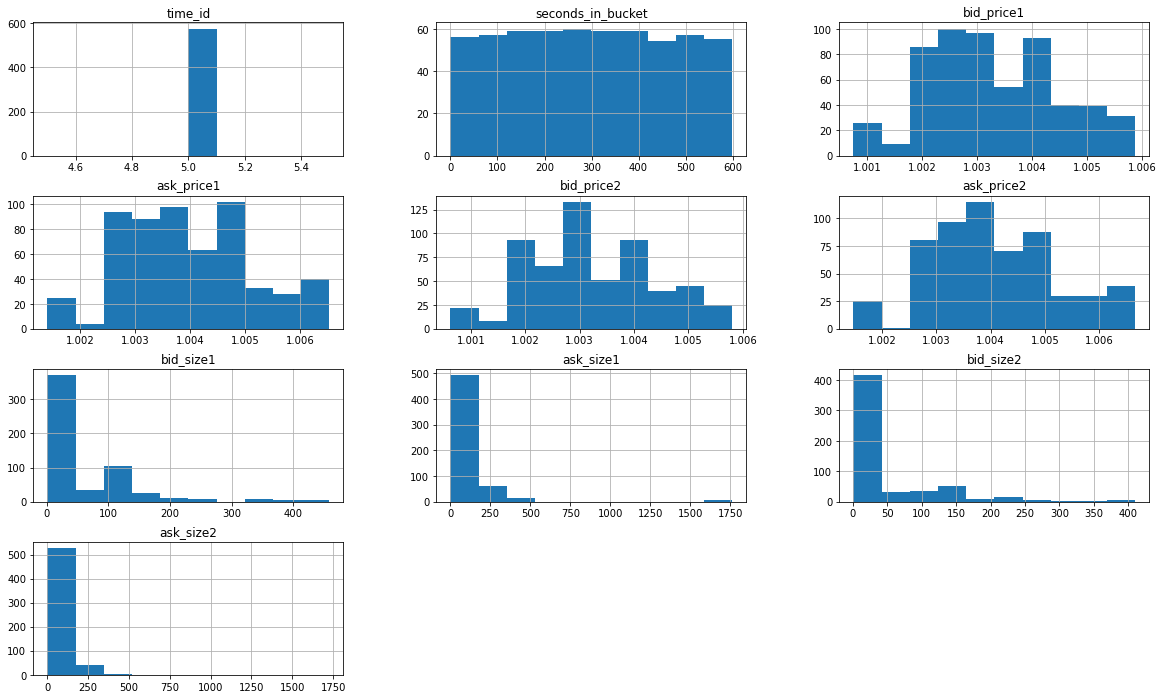

In [59]:
book_study.hist(figsize=(20,12))
plt.show()

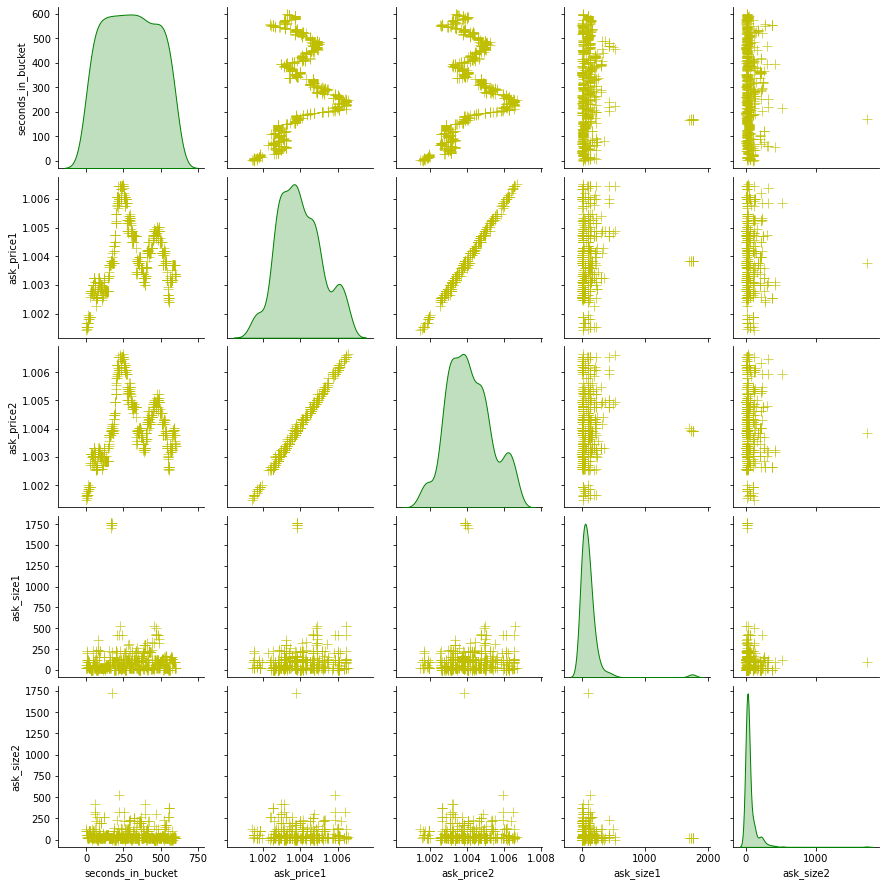

In [28]:
sns.pairplot(
    book_study[['seconds_in_bucket','ask_price1','ask_price2','ask_size1','ask_size2']], 
    kind='scatter', 
    diag_kind='kde', 
    diag_kws=dict(shade=True, color='g'),
    plot_kws=dict(s=100, color='y', alpha=0.8),
    markers="+",
    height=2.5
    )
plt.show()

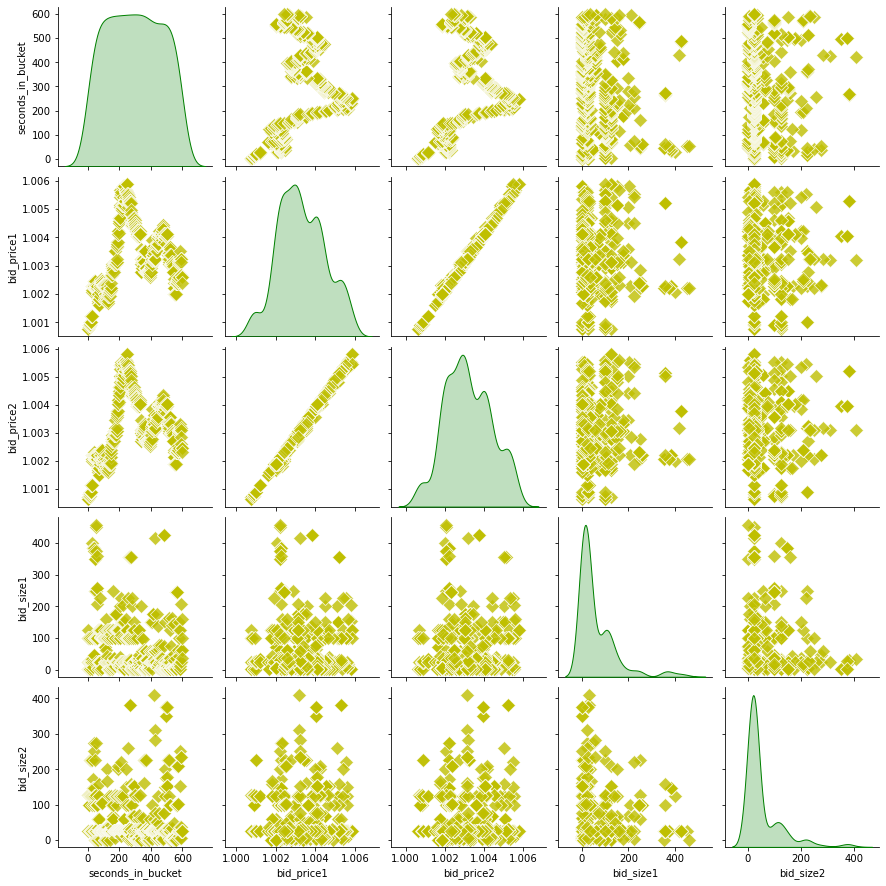

In [29]:
sns.pairplot(
    book_study[['seconds_in_bucket','bid_price1','bid_price2','bid_size1','bid_size2']],
    kind='scatter', 
    diag_kind='kde', 
    diag_kws=dict(shade=True, color='g'),
    plot_kws=dict(s=100, color='y', alpha=0.8),
    markers="D",
    height=2.5
)
plt.show()

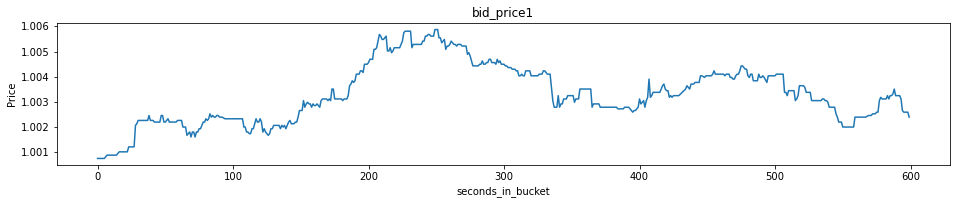

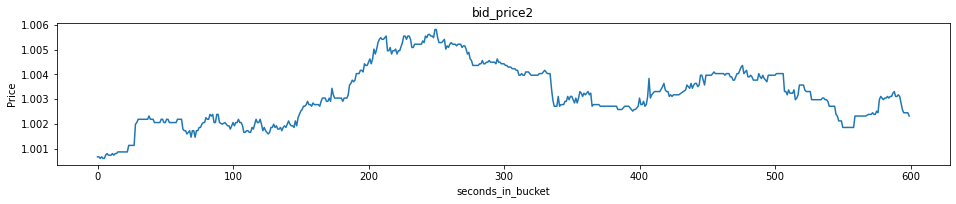

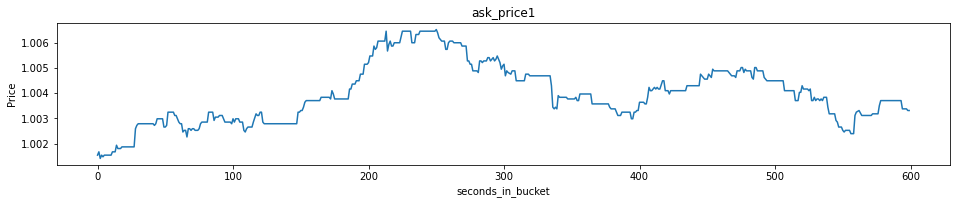

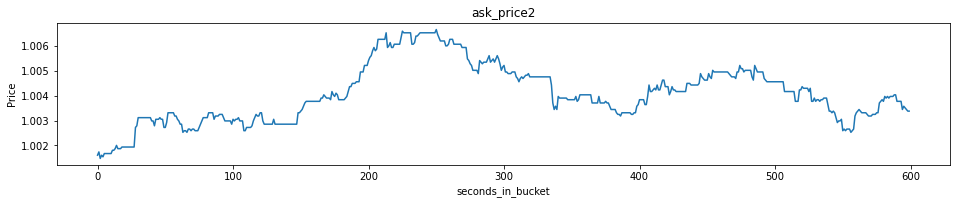

In [38]:
select_price = ['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2']

for num, name in enumerate(select_price):
    plt.figure(figsize=(16, 12))
    plt.subplot(4, 1, num + 1)
    plt.plot(book_study['seconds_in_bucket'], book_study[name])
    plt.xlabel('seconds_in_bucket')
    plt.ylabel('Price')
    plt.title(name)
plt.show()

**5.2 Trade (train) Parquet**

In [39]:
pd.concat([trade_study.head(), trade_study.tail()])

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,28,1.002080,553,11,1
1,5,39,1.002460,8,3,1
2,5,42,1.002308,147,4,1
3,5,44,1.002788,1,1,1
4,5,51,1.002657,100,2,1
89,5,577,1.003110,341,12,1
90,5,578,1.003510,24,4,1
91,5,589,1.003510,11,1,1
92,5,593,1.003248,6,3,1
93,5,594,1.003116,209,4,1


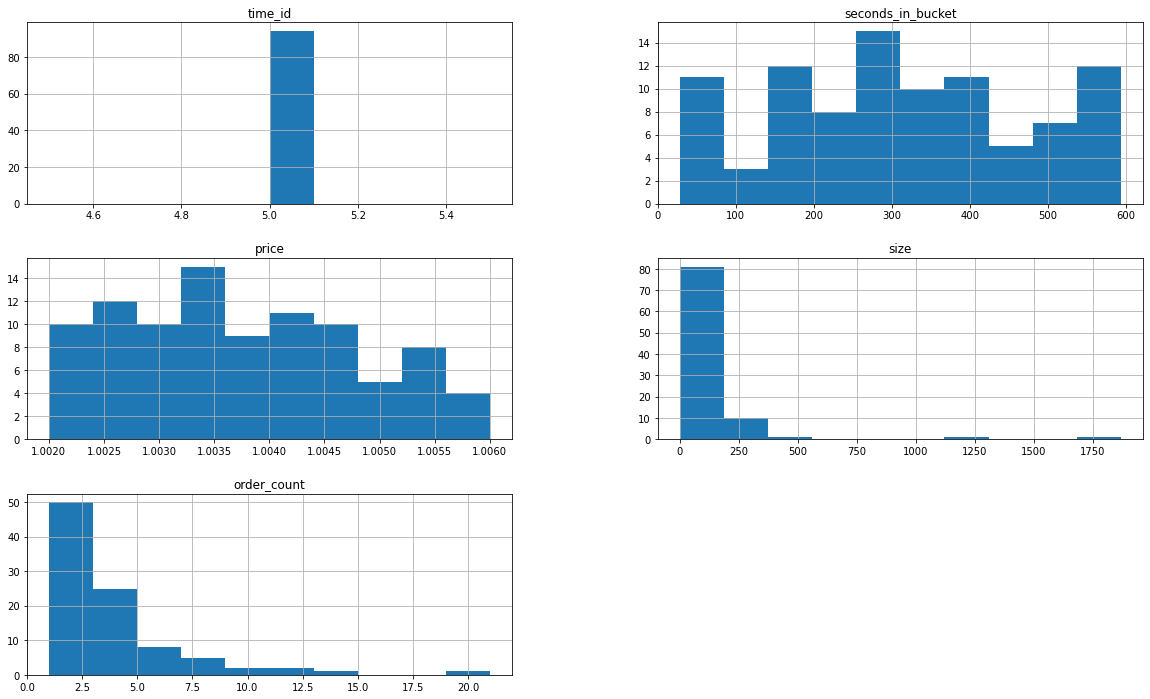

In [40]:
trade_study.hist(figsize=(20,12))
plt.show()

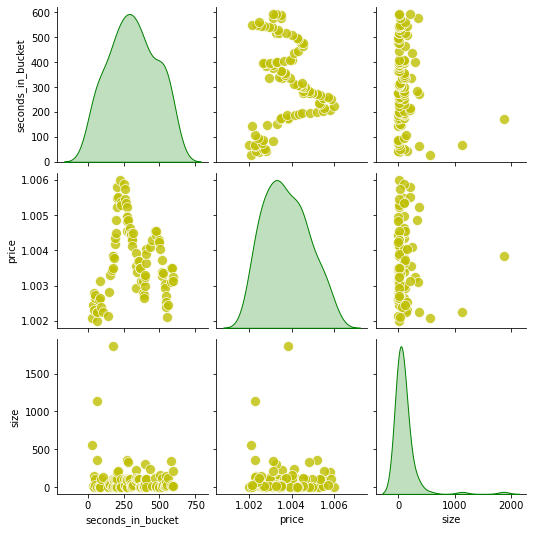

In [41]:
sns.pairplot(
    trade_study[['seconds_in_bucket','price','size']], 
    kind='scatter', 
    diag_kind="kde", 
    diag_kws=dict(shade=True, color='g'),
    plot_kws=dict(s=100, color='y', alpha=0.8),
    height=2.5
)
plt.show()

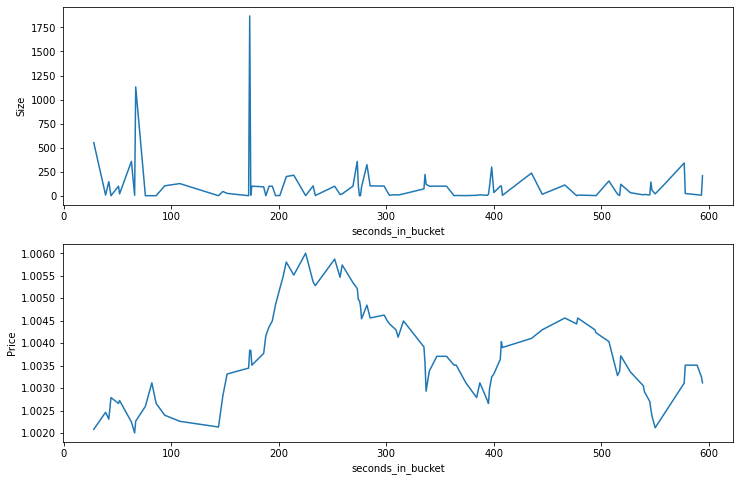

In [42]:
fig, ax = plt.subplots(2, figsize=(12, 8))
ax[0] = sns.lineplot(data=trade_study, x="seconds_in_bucket", y="size", ax=ax[0])
ax[0].set_ylabel('Size')
ax[1] = sns.lineplot(data=trade_study, x="seconds_in_bucket", y="price", ax=ax[1])
ax[1].set_ylabel('Price')
plt.show()

**5.3 Comprehensive Chart combines bid/ask price & deal price**

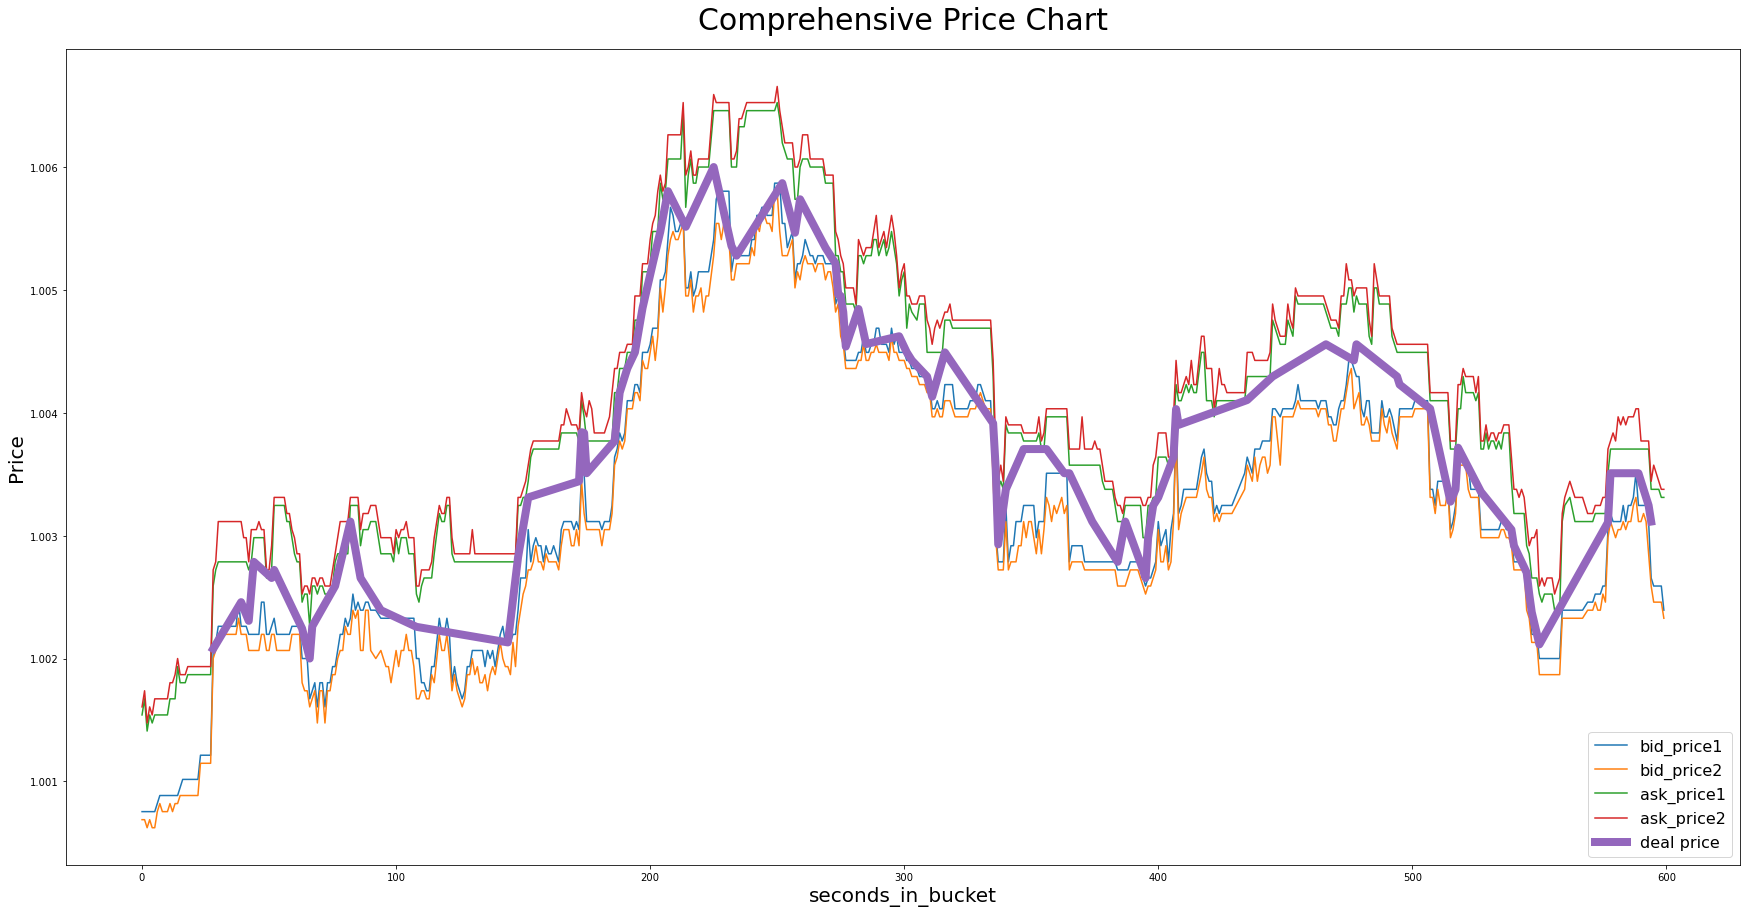

In [43]:
plt.figure(figsize=(30, 15))
for num, name in enumerate(select_price):
    plt.plot(book_study['seconds_in_bucket'], book_study[name], label=name)
plt.plot(trade_study['seconds_in_bucket'], trade_study['price'], label='deal price',lw=8)
plt.legend(loc=4, fontsize=16)
plt.xlabel('seconds_in_bucket', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.title('Comprehensive Price Chart', fontsize=30, pad=20)
plt.show()

The deal price is the price at which the bid price equals to the ask price, thus the deal is successfully made.

### 6. Recovery on original prices

In [45]:
pd.concat([trade.head(), trade.tail()])

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0
38382736,32767,570,0.999932,100,1,99
38382737,32767,575,0.999932,100,1,99
38382738,32767,579,0.999797,300,3,99
38382739,32767,584,0.999854,172,2,99
38382740,32767,592,0.999662,400,5,99


Stock prices are changing by multiples of minimum possible price change called **tick size**, which is usually equals to 0.01.

The **prices** showed in the sheet are normalized by dividing them by the weighted average price(WAP) at seconds_in_bucket = 0. So does the tick size.

Therefore, we need to denormalize the prices in the sheet to get their original prices.

In [104]:
df_files = pd.DataFrame({'book_path': glob(f'{Data_Directory}/book_train.parquet/**/*.parquet')}) \
    .assign(stock_id=lambda x: x.book_path.str.extract("stock_id=(\d+)").astype('int')) \
    .sort_values('stock_id')
r = df_files.query(f'stock_id == {stock_id}').iloc[0]

# recover original prices(denormalize) for all stock_id/time_id
def recover_original_price(df):
    diff = abs(df.diff())
    min_diff = np.nanmin(diff[diff > 0])
    tick_num = np.round(diff / min_diff)
    # assume tick size equals to 0.01 and is constant
    return 0.01 / np.nanmean(diff / tick_num)

def recover_original_prices(r):
    df = pd.read_parquet(r.book_path, columns=['time_id', 'ask_price1', 'ask_price2', 'bid_price1', 'bid_price2'])
    df = df.groupby('time_id').apply(recover_original_price).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df 

df_prices_original = pd.concat(Parallel(verbose=0, n_jobs=-1)(delayed(recover_original_prices)(r) for _, r in df_files.iterrows()))
df_prices_original = df_prices_original.pivot('time_id', 'stock_id', 'price')
df_prices_original

/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:9: RuntimeWarning: All-NaN axis encountered
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:11: RuntimeWarning: Mean of empty slice
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:9: RuntimeWarning: All-NaN axis encountered
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:11: RuntimeWarning: Mean of empty slice
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:9: RuntimeWarning: All-NaN axis encountered
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:11: RuntimeWarning: Mean of empty slice
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:9: RuntimeWarning: All-NaN axis encountered
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm00000gn/T/ipykernel_13547/344491345.py:11: RuntimeWarning: Mean of empty slice
/var/folders/yc/c9r9rmv518z_pbbwhf9cjsm0

stock_id,0,1,2,3,4,5,6,7,8,9,...,115,116,118,119,120,122,123,124,125,126
time_id,,,,,,,,,,,,,,,,,,,,,
5,193.382499,152.416327,123.461428,226.012232,619.198910,738.256609,370.275801,245.870983,283.881404,238.394801,...,88.143530,246.326035,210.790493,66.225351,96.217049,142.352639,108.310134,84.344766,53.375172,310.446018
11,199.230489,149.512019,128.641219,249.893186,614.775587,769.481159,411.690103,256.711224,278.116800,244.391095,...,90.285607,275.920002,213.987639,63.064600,101.239489,136.924692,105.482065,91.095218,55.886795,300.948142
16,208.900108,104.885672,118.687626,164.755260,534.006468,584.016561,236.595134,208.127709,123.656642,177.405905,...,70.035150,189.724268,281.007926,53.520546,74.554427,93.370637,77.421019,55.054433,53.084003,194.495613
31,216.138269,137.831207,138.326846,235.951400,657.637025,804.561657,358.949356,260.607163,194.206656,232.626591,...,90.688217,256.869865,235.129520,61.245171,90.928457,134.847296,103.739264,92.465027,58.124482,259.149062
62,214.516335,140.650237,137.213402,238.242521,639.647230,765.430361,403.068356,250.621870,187.756607,243.460002,...,89.140911,248.061738,231.193774,59.542960,87.940275,125.482870,103.529649,96.060419,57.373160,259.214214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32751,192.207769,148.865368,132.110590,243.722214,652.082489,745.338533,389.702447,252.020435,252.114143,230.046724,...,88.523948,269.021445,241.987520,60.049757,93.429990,135.630818,103.531318,94.184826,56.814400,306.255498
32753,199.748994,143.562752,128.829956,245.019729,616.837441,755.527664,389.036260,249.891005,258.463170,241.465759,...,91.186063,269.457870,212.935865,62.066114,92.794336,136.533152,104.054983,87.874304,55.995629,290.136260
32758,198.471328,111.979022,142.683929,216.825656,591.479678,729.433334,509.977233,234.174952,132.590478,206.086532,...,80.310357,225.500215,211.873457,43.955594,80.582209,111.225451,89.826475,81.064096,56.597615,202.570521


Text(0.5, 1.0, 'Original Price Distribution')

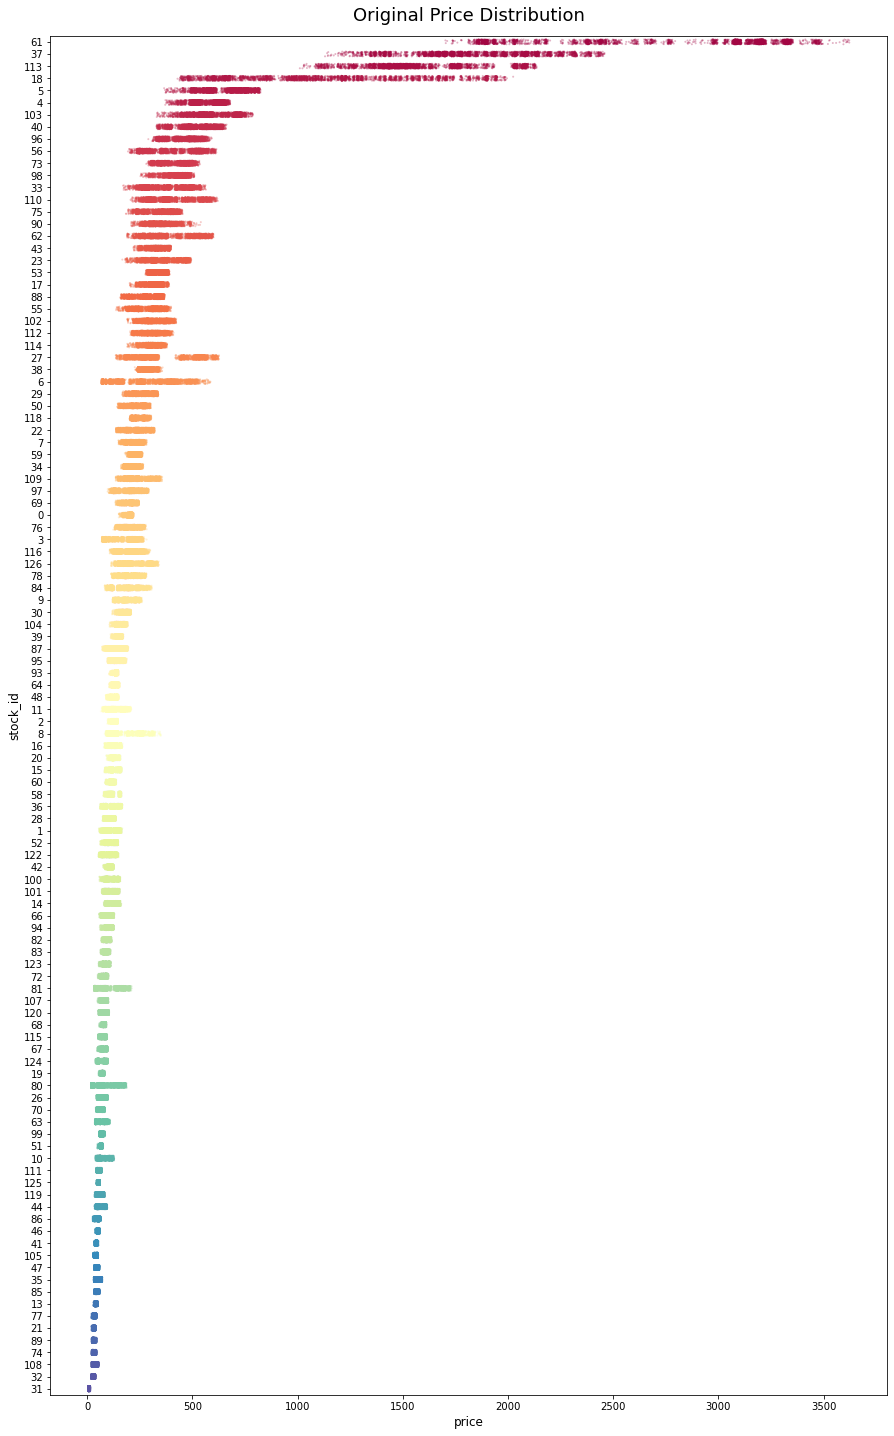

In [78]:
# plot each stock's original price distribution by its stock_id
plt.figure(figsize=(15, 25))
ax = sns.stripplot(
    data=df_prices_original, 
    orient='h', 
    alpha=0.3, 
    s=2, 
    jitter=0.2,
    order=df_prices_original.median().sort_values().index[::-1].tolist(), 
    palette='Spectral'
    )
ax.tick_params(axis='y', which='major', labelsize=10)
plt.xlabel('price', size=12)
plt.ylabel('stock_id', size=12)
plt.title('Original Price Distribution', size=18, pad=15)

### 7. Rescovery on time sequence from original prices

In [97]:
# define necessary variables and functions needed for the plotting
df_prices_original_scaled = df_prices_original.fillna(df_prices_original.mean())
df_prices_original_scaled = pd.DataFrame(minmax_scale(df_prices_original_scaled), index=df_prices_original.index)

df_target_train = pd.read_csv(Data_Directory + 'train.csv')
df_volatility_train = df_target_train.groupby('time_id').target.mean()

def plot_emb(emb, color, name, kind='volatility', fig=None, ax=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))
    if kind == 'volatility':
        norm = mpl.colors.LogNorm()
        ticks = mpl.ticker.LogLocator(2)
        formatter = mpl.ticker.ScalarFormatter()
    elif kind == 'date':
        norm = None
        ticks = None
        formatter = mpl.dates.AutoDateFormatter(mpl.dates.MonthLocator())
    plot = ax.scatter(emb[:, 0], emb[:, 1], s=3, c=color, edgecolors='none', cmap='jet', norm=norm)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.2)    
    cb = fig.colorbar(plot, label=kind, format=formatter,
                      ticks=ticks, cax=cax)
    cb.ax.minorticks_off()
    ax.set_title(f'{name}')

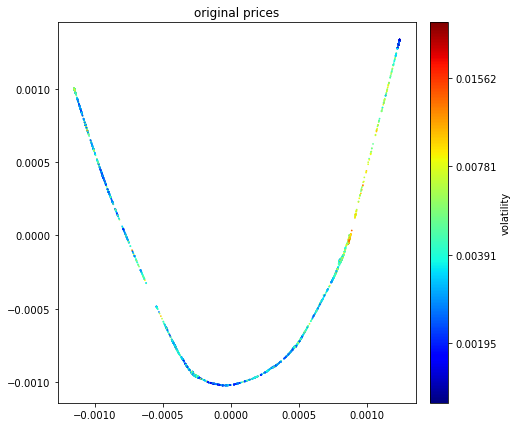

In [107]:
# use Spectral Embedding to reduce dimentiionality and show the plot
df_prices_embedded = SpectralEmbedding(random_state=2).fit_transform(df_prices_original_scaled)
plot_emb(df_prices_embedded, df_volatility_train, 'original prices', 'volatility')
plt.show()

Long continuous segments shown in the plot, indicating that close time_ids are close in the space.

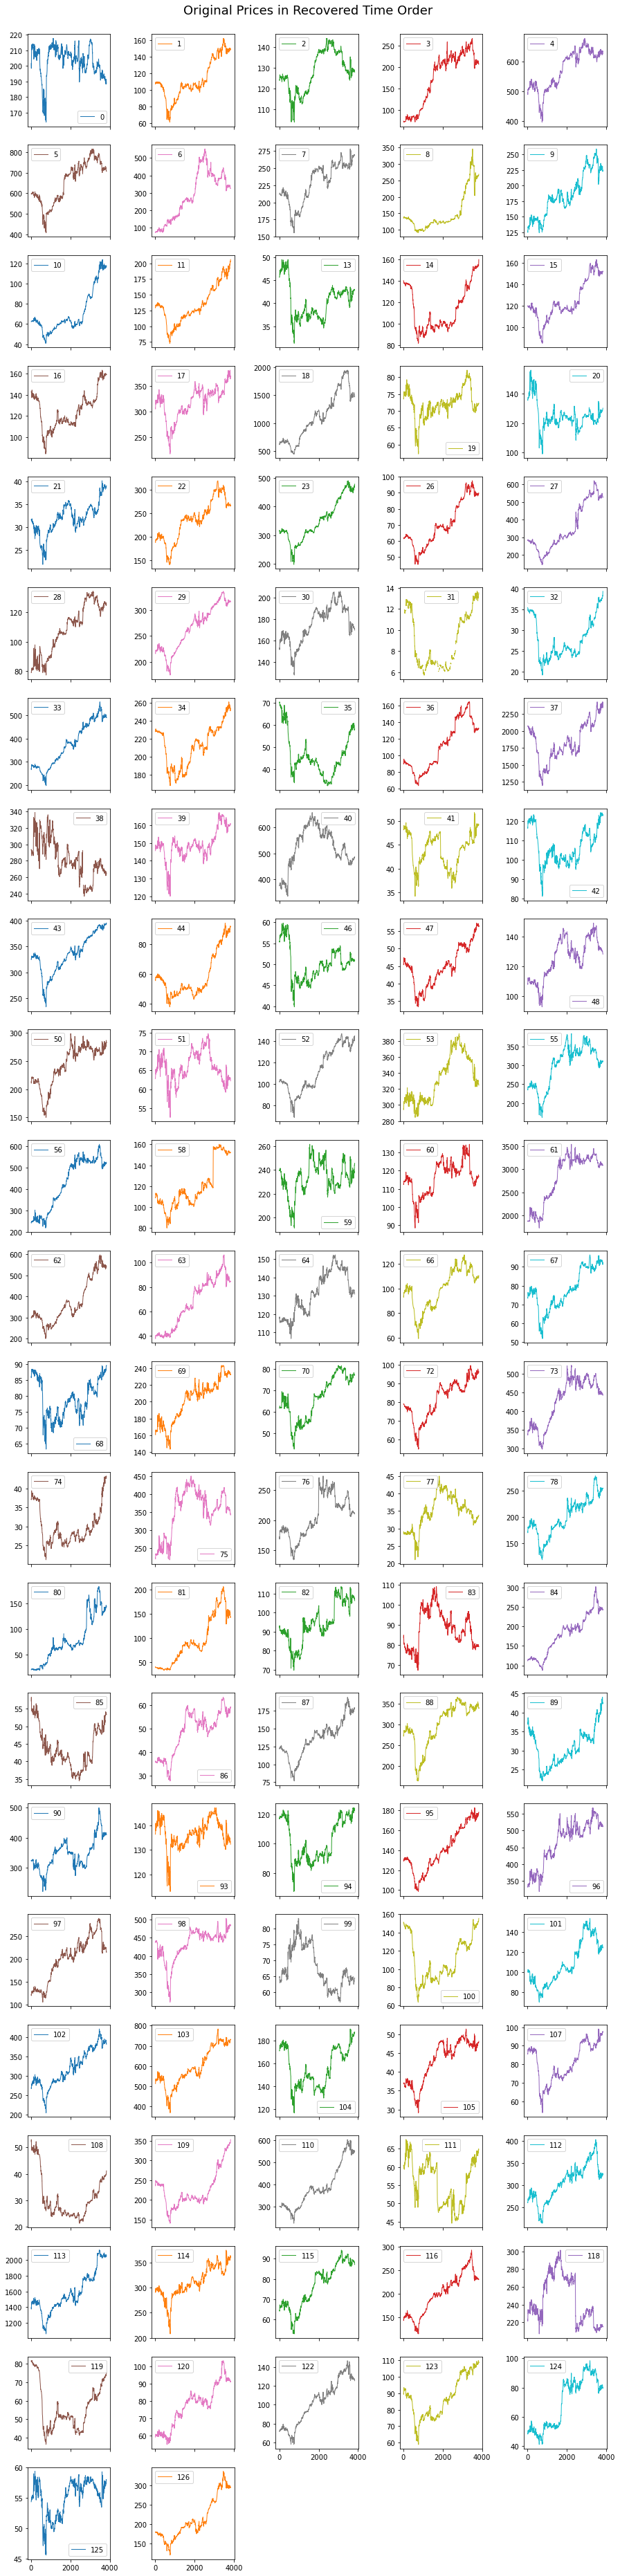

In [109]:
# show changes of each stock's original price along the recovered time sequence
df_prices_original_ordered = df_prices_original.iloc[np.argsort(-df_prices_embedded[:, 0])]

df_prices_original_ordered.reset_index(drop=True).rolling(10).mean(). \
    plot(subplots=True, layout=(-1, 5), figsize=(15, 60), sharex=True, lw=1)
plt.suptitle('Original Prices in Recovered Time Order', size=18)
plt.subplots_adjust(top=0.97, wspace=0.5)